模型参数: [-3.65153202 18.13566179 -1.22475842]
测试集准确率: 0.8333333333333334


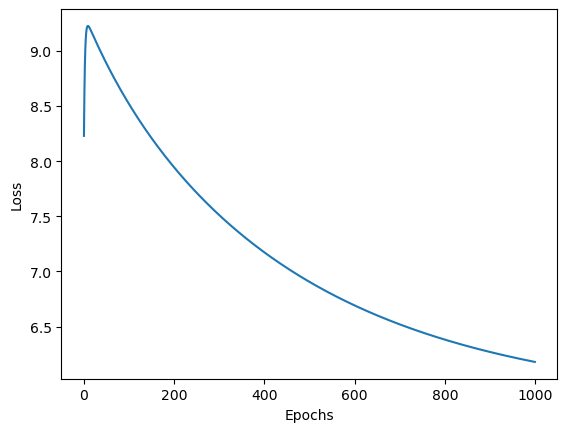

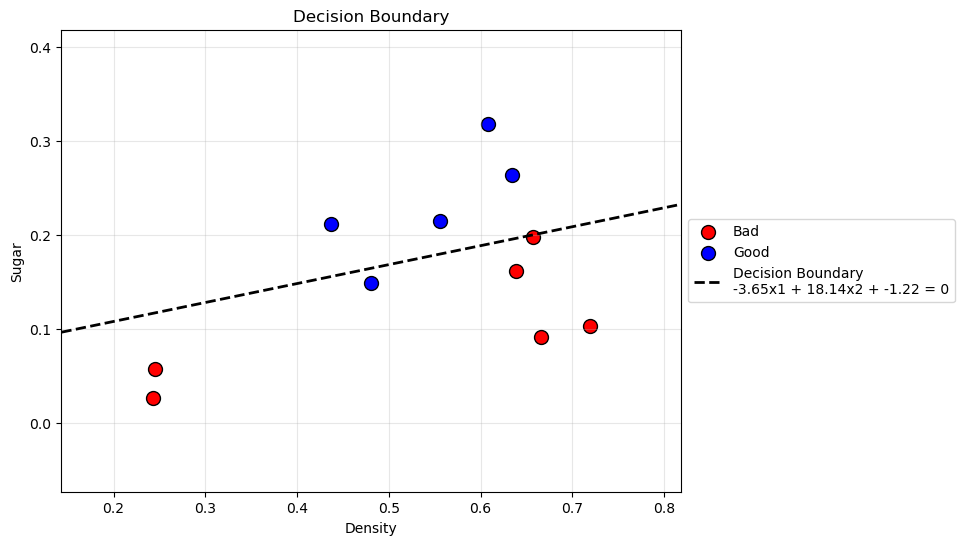

In [1]:
#########手动编程进行逻辑回归#########
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

class LogisticRegression:
    def __init__(self,fit_intercept=True,method='batch',
                 learning_rate=0.1,max_iter=1000,random_state=None):
        """
        逻辑回归分类器
        
        参数:
        - fit_intercept: 是否添加偏置项 (默认True)
        - method: 优化方法 ['batch'(批量梯度下降), 'stochastic'(随机梯度下降)] (默认'batch')
        - learning_rate: 学习率 (默认0.1)
        - max_iter: 最大迭代次数 (默认500)
        - random_state: 随机种子 (默认None)
        """
        self.fit_intercept = fit_intercept
        self.method = method
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state
        self.beta = None
        self.loss_history = []

    def add_intercept(self,X):
        """设置偏置项(X,1)"""
        if self.fit_intercept:
            return np.c_[X,np.ones(X.shape[0])]
        else:
            return X
        
    def sigmoid(self,z):
        """sigmoid函数"""
        return 1.0 / (1.0 + np.exp(-z))
    
    def loss(self,X,y):
        """计算似然损失(3.27)"""
        z = X @ self.beta
        loss_terms = -y * z + np.log(1 + np.exp(-z))
        return np.sum(loss_terms)

    def batch_gradient_step(self,X,y):
        """批量梯度下降更新参数(3.30)""" 
        p = self.sigmoid(X @ self.beta)
        gradent = X.T @ (p - y)
        self.beta -= self.learning_rate * gradent

    def stochastic_gradient_step(self,X,y):
        """随机梯度下降更新参数(一次随机更新一个方向)"""
        for i in range(X.shape[0]):
             p = self.sigmoid(X[i] @ self.beta)
             gradent = X[i] * (p - y[i])
             self.beta -= self.learning_rate * gradent
        
    def fit(self,X,y):
        """
        训练模型
        
        参数:
        - X: 特征矩阵 (n_samples, n_features)
        - y: 标签向量 (n_samples,)
        """

        # 数据预处理(m个数据，n-1个特征)
        X = self.add_intercept(X)
        m,n = X.shape
        self.beta = np.zeros(n)

        # 设置随机种子
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # 选择优化方法
        if self.method == 'batch':
            optimizer = self.batch_gradient_step
        elif self.method =='stochastic':
            optimizer = self.stochastic_gradient_step
        else:
            raise ValueError("method must be 'batch' or'stochastic'")

        # 训练模型
        for epoch in range(self.max_iter):
            # 随机梯度下降每次迭代后随机打乱数据
            if self.method == 'stochastic':
                X,y = shuffle(X,y)

            # 执行一次梯度下降更新
            optimizer(X,y)

            # 记录损失
            self.loss_history.append(self.loss(X,y))

        return self
    
    def predict_proba(self,X):
        """返回预测概率"""
        X = self.add_intercept(X)
        return self.sigmoid(X @ self.beta)
    
    def predict(self,X):
        """返回预测类别"""
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def score(self,X,y):
        """计算准确率"""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def plot_loss_curve(self):
        """绘制损失变化图"""
        plt.plot(self.loss_history)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

    def plot_decision_boundary(self,X,y):
        """绘制决策边界"""
        if X.shape[1] != 2:
            raise ValueError("只支持二维特征可视化!")
        # 提取模型参数
        w1, w2, b = self.beta[0], self.beta[1], self.beta[2]
        
        # 生成网格点坐标
        x_min, x_max = X[:,0].min()-0.1, X[:,0].max()+0.1
        y_min, y_max = X[:,1].min()-0.1, X[:,1].max()+0.1
        xx = np.linspace(x_min, x_max, 100)
        
        # 计算决策边界直线方程：w1*x1 + w2*x2 + b = 0 → x2 = (-w1*x1 -b)/w2
        decision_line = (-w1 * xx - b) / w2
        
        # 创建画布
        plt.figure(figsize=(8,6))
        
        # 绘制原始数据点
        plt.scatter(X[y==0][:,0], X[y==0][:,1], color='red', 
                    edgecolor='k', s=100, label='Bad')
        plt.scatter(X[y==1][:,0], X[y==1][:,1], color='blue', 
                    edgecolor='k', s=100, label='Good')
        
        # 绘制决策边界
        plt.plot(xx, decision_line, 'k--', lw=2, 
                label=f'Decision Boundary\n{w1:.2f}x1 + {w2:.2f}x2 + {b:.2f} = 0')
        
        # 美化显示
        plt.xlabel("Density")
        plt.ylabel("Sugar")
        plt.title("Decision Boundary")
        plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.grid(alpha=0.3)
        plt.show()
        

if __name__ == '__main__':
    # 加载数据
    dataset = np.loadtxt('../Data/watermelon_3a.csv', delimiter=',')
    X = dataset[:, 1:3]
    y = dataset[:, 3]

    # 划分数据集(0.3的测试集)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # 初始化模型(批量梯度下降)
    model = LogisticRegression(
        method='batch',       
        learning_rate=0.1,
        max_iter=1000,
        random_state=42
    )

    # 训练模型
    model.fit(X_train, y_train)

    # 评估模型
    print("模型参数:", model.beta)
    print("测试集准确率:", model.score(X_test, y_test))

    # 损失可视化
    model.plot_loss_curve()

    # 决策边界可视化
    model.plot_decision_boundary(X_train, y_train)